In [1]:
''' Set the environment  '''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,Draw
from rdkit.Chem import MCS
import pandas as pd
import numpy as np
import copy,re
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
from my_toolset.my_utils import get_mol,compute_FP,canonic_smiles,mapper,weight
from my_toolset.drawing_utils import show_mols
import os,sys
sys.path.append("../")
from utils.common_utils import mapper,csvToExcel,get_mol,compute_FP,canonic_smiles,float_row,heavy_atm_smiles,kekulize_smi,sort_mol_sim_df
from utils.sarm_utils import get_core

from IPython.display import display, SVG, display_svg
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path
import glob
from functools import partial
from pandarallel import pandarallel
n_jobs=40
pandarallel.initialize(nb_workers=n_jobs)

def kekulize_smi(smi):
    try:
        mol=get_mol(smi)
        Chem.Kekulize(mol)
        smi=Chem.MolToSmiles(mol, kekuleSmiles=True)
        return smi
    except Exception as e:
        print(e)
        return smi

def remove_dummy(smi):
    FragMol=Chem.MolFromSmiles(smi)
    matched=FragMol.GetSubstructMatches(Chem.MolFromSmarts("[#7][#0]"))
    atoms=FragMol.GetAtoms()
    for imatch in matched:
        atoms[imatch[1]].SetAtomicNum(1)
    # imol.UpdatePropertyCache()
    Chem.SanitizeMol(FragMol)
    FragMol=Chem.RemoveHs(FragMol)
    smi=Chem.MolToSmiles(FragMol)
    re_p=re.compile(r'\(\*\)|\*|\[\*\]|\-')
    ifrag_nodummy = re.sub(re_p, '', smi)  ## remove dummy atoms
    return ifrag_nodummy
    
def get_RGrps_dummy(mol,Core_smi):
    mol=get_mol(mol)
    # FragMol=get_mol(Frag_smi)
    CoreMol=Chem.MolFromSmarts(Core_smi)  ### Must be read as SMARTS
    matchedFrag=mol.GetSubstructMatches(CoreMol)[0]  ## Only the first match will be considered!
    print(matchedFrag)
    matchedDummy=CoreMol.GetSubstructMatches(Chem.MolFromSmarts('[*][#0]'))  ##[CoreAtom, DummyAtom]
    if len(matchedDummy)==2:
        if matchedDummy[0][1]>matchedDummy[1][1]:
            matchedDummy=[matchedDummy[1],matchedDummy[0]]
    print(matchedDummy)
    BondList=[]
    AtomPairList=[]
    '''  Put the dummy atoms in order  '''
    
    for imatDummy in matchedDummy:
        bond_coreAtom=matchedFrag[imatDummy[0]]
        bond_RAtom=matchedFrag[imatDummy[1]]
        AtomPairList.append([bond_coreAtom, bond_RAtom])
        bond=mol.GetBondBetweenAtoms(bond_coreAtom, bond_RAtom).GetIdx()
        BondList.append(bond)
    dummyLabels=[(0, 0) for ibond in BondList]    
    FragedMol= Chem.FragmentOnBonds(mol, BondList, dummyLabels=dummyLabels)
    '''  Get the Fragments  '''
    fragSmis=[get_frag(FragedMol, iatomPair[1]) for iatomPair in AtomPairList]
    return fragSmis

def get_frag(fraged_mol, atomIdx):
    Atoms=fraged_mol.GetAtoms()
    count=0
    newAtoms=[Atoms[atomIdx]]
    RAtomIdx=[atomIdx]
    while len(newAtoms) > 0:
        count+=1
        tmpAtoms=[]
        for iAtom in newAtoms:
            negbs=iAtom.GetNeighbors()
            for inegb in negbs:
                inegbIdx=inegb.GetIdx()
                if inegbIdx not in RAtomIdx:
                    RAtomIdx.append(inegbIdx)
                    tmpAtoms.append(inegb)
        newAtoms=tmpAtoms
        if count>100:  ## get avoid of dead circle
            break
        # frag_smi = Chem.MolFragmentToSmiles(mol, RAtomIdx, canonical=True,isomericSmiles=False,kekuleSmiles=True) 
        frag_smi = Chem.MolFragmentToSmiles(fraged_mol, RAtomIdx, canonical=True,isomericSmiles=False) 
    return kekulize_smi(frag_smi)

def combine_CombTab_Fround1(combTable,FRound1):
    df_combTable=pd.read_csv(combTable)
    df_combTable.columns=['Table','SMILES','Size','Count']
    df_FRound1=pd.read_csv(FRound1)
    df_FRound1.columns=['SMILES','Count']
    df_FRound1['Size']=[f'({i})' for i in df_FRound1['Count']]
    
    df_FRound1=df_FRound1[['SMILES','Size']]
    df_combTable=df_combTable[['SMILES','Size']]
    df_comb=pd.concat([df_FRound1,df_combTable])
    return df_comb

def replace_nH(ismarts):
    ismarts=ismarts.replace('[nH]','n')
    ismarts=ismarts.replace('-','')
    return ismarts

def add_singleBond_dummy(smarts):
    newSmarts=''
    for idx,ilet in enumerate(smarts):
        if idx==0 and ilet=='*':
            newSmarts+='*-'
        elif idx==len(smarts)-1 and ilet=='*':
            newSmarts+='-*'
        elif ilet=='*':
            newSmarts+='-*'
        else:
            newSmarts+=ilet
    return newSmarts
        
def match_frag(ismi,ismarts):
    # print("ismi",ismi)
    # print("ismarts",ismarts)
    mol = Chem.MolFromSmiles(ismi)
    ismarts=replace_nH(ismarts)
    smartsMol = Chem.MolFromSmarts(ismarts) #,sanitize=False
    matched=mol.GetSubstructMatches(smartsMol)
    if len(matched)>0:
        # print(matched)
        return 1
    else:
        return 0
    
def get_activity_info(frag, file_act, cols):
    df_act=pd.read_csv(file_act)
    df_act['matched']=df_act.apply(lambda x: match_frag(x['Cano_SMILES'],ismarts=frag),axis=1)
    df_match=df_act[df_act['matched']==1]
    # print(df_match)
    if len(df_match)==0:
        return [['','',''] for icol in cols]
    if len(df_match)==1:
        means=df_match.iloc[0]
        stds=df_match.iloc[0]
        medians=df_match.iloc[0]
    if len(df_match)>1:
        means=df_match.mean().round(2)
        stds=df_match.std().round(2)
        medians=df_match.median().round(2)
    res=[]
    for icol in cols:
        res+=[means[icol],stds[icol],medians[icol]] 
    return res

def add_singleBond_dummy(smarts):
    newSmarts=''
    for idx,ilet in enumerate(smarts):
        if idx==0 and ilet=='*':
            newSmarts+='*!@'
        elif idx==len(smarts)-1 and ilet=='*':
            newSmarts+='!@*'
        elif ilet=='*':
            newSmarts+='!@*'
        else:
            newSmarts+=ilet
    return newSmarts


    
def get_full_core(smi, Core_smi):
    mol=get_mol(smi)
    # FragMol=get_mol(Frag_smi)
    CoreMol=Chem.MolFromSmarts(Core_smi)  ### Must be read as SMARTS
    
    # matchedFrag=mol.GetSubstructMatches(CoreMol)[0]  ## Only the first match will be considered!
    for matchedFrag in mol.GetSubstructMatches(CoreMol):
        # print(matchedFrag)
        matchedDummy=CoreMol.GetSubstructMatches(Chem.MolFromSmarts('[*][#0]'))  ##[CoreAtom, DummyAtom]
        if len(matchedDummy)==2:
            if matchedDummy[0][1]>matchedDummy[1][1]:
                matchedDummy=[matchedDummy[1],matchedDummy[0]]
        # print(matchedDummy)
        BondList=[]
        AtomPairList=[]
        '''  Put the dummy atoms in order  '''
        
        for imatDummy in matchedDummy:
            bond_coreAtom=matchedFrag[imatDummy[0]]
            bond_RAtom=matchedFrag[imatDummy[1]]
            AtomPairList.append([bond_coreAtom, bond_RAtom])
            bond=mol.GetBondBetweenAtoms(bond_coreAtom, bond_RAtom)
            if not bond.IsInRing():
                BondList.append(bond.GetIdx())
        
    if len(BondList)>0:
        dummyLabels=[(0, 0) for ibond in BondList]    
        FragedMol= Chem.FragmentOnBonds(mol, BondList, dummyLabels=dummyLabels)
        '''  Get the Fragments  '''
        coreSmi=get_frag(FragedMol, AtomPairList[0][0])
        return coreSmi
    else:
        print(smi,Core_smi)
        return ''

def is_number(InString):
    try:
        string_num=float(InString)
        return string_num
    except Exception as e:
        return ''
    
'''  Create Tree Utils  '''
def is_parent(parent,child):
    '''  If the compound is a substructure of another and don't have a molecule as its own substurcture, it's a parent.  '''
    parent=parent.replace('[nH]','n')  ## Correct the influence of ionization
    mol_parent=Chem.rdmolfiles.MolFromSmarts(parent)
    mol_child=Chem.rdmolfiles.MolFromSmiles(child,sanitize=False)
    mol_child.UpdatePropertyCache()
    matched=mol_child.GetSubstructMatches(mol_parent)
    if len(matched)>0:
        # print(matched)
        return True
    else:
        return False
    
def is_child(child,parent):
    '''  If the compound is a substructure of another and don't have a molecule as its own substurcture, it's a parent.  '''
    parent=parent.replace('[nH]','n')  ## Correct the influence of ionization
    mol_parent=Chem.rdmolfiles.MolFromSmarts(parent)
    mol_child=Chem.rdmolfiles.MolFromSmiles(child,sanitize=False)
    mol_child.UpdatePropertyCache()
    matched=mol_child.GetSubstructMatches(mol_parent)
    if len(matched)>0:
        # print(matched)
        return True
    else:
        return False

def remove_dummy(smi):
    FragMol=Chem.MolFromSmiles(smi)
    matched=FragMol.GetSubstructMatches(Chem.MolFromSmarts("[#7][#0]"))
    atoms=FragMol.GetAtoms()
    for imatch in matched:
        atoms[imatch[1]].SetAtomicNum(1)
    # imol.UpdatePropertyCache()
    Chem.SanitizeMol(FragMol)
    FragMol=Chem.RemoveHs(FragMol)
    smi=Chem.MolToSmiles(FragMol)
    re_p=re.compile(r'\(\*\)|\*|\[\*\]|\-')
    ifrag_nodummy = re.sub(re_p, '', smi)  ## remove dummy atoms
    return ifrag_nodummy

def real_sonNode(smi,children_smis,parent_dict):
    has_parent=set(children_smis) & set(parent_dict[smi])
    # print(has_parent)
    # sys.exit()
    if len(has_parent)>0:
        return False
    else:
        return True

def remove_ionizationForm(smiList):
    '''  Remove the same compounds with different ionization state '''
    lenSmiList=len(smiList)
    rmIndex=[]
    for i,ismi in enumerate(smiList):
        for j in range(i+1,lenSmiList,1):
            jsmi=smiList[j]
            if is_child(ismi,jsmi) and is_child(jsmi,ismi):
                rmIndex.append(j)
    smiList=np.array(smiList)
    smiList=np.delete(smiList, list(set(rmIndex)))
    return smiList

def find_children_single(ismi,smi_list):
    children_list=[]
    for jsmi in smi_list:
        if ismi==jsmi: 
            continue
        if is_child(ismi,jsmi):
            children_list.append([ismi, jsmi]) 
    return children_list

def find_children(smi_list):
    find_children_single_p=partial(find_children_single,smi_list=smi_list)
    key_values=mapper(n_jobs)(find_children_single_p,smi_list)
    res_dict={}
    for ismi in smi_list:
        res_dict[ismi]=[]
    for ikey_value_list in key_values:
        if len(ikey_value_list)==0:
            continue
        for ikey_value in ikey_value_list:
            res_dict[ikey_value[0]].append(ikey_value[1])
    return res_dict

def find_parents_single(ismi,smi_list):
    # res_dict[ismi]=[]
    parents_list=[]
    for jsmi in smi_list:
        if ismi==jsmi: 
            continue
        if is_child(jsmi,ismi):
            parents_list.append([ismi,jsmi]) 
    return parents_list

def find_parents(smi_list):
    find_parents_single_p=partial(find_parents_single, smi_list=smi_list)
    key_values=mapper(n_jobs)(find_parents_single_p, smi_list)
    res_dict={}
    for ismi in smi_list:
        res_dict[ismi]=[]
    for ikey_value_list in key_values:
        if len(ikey_value_list)==0:
            continue
        for ikey_value in ikey_value_list:
            res_dict[ikey_value[0]].append(ikey_value[1])
    return res_dict

def if_root(ismi,smi_list):
    has_parent=False
    has_child=False 
    for jsmi in smi_list:
        if ismi==jsmi:
            continue
        # print(ismi,jsmi)
        if is_child(ismi,jsmi):
            has_child=True
        if is_child(jsmi,ismi):
            has_parent=True
        if has_child and has_parent:
            return None
    if has_child and not has_parent:
        return ismi    

def find_root(smi_list): 
    if_root_p=partial(if_root,smi_list=smi_list)
    roots=mapper(n_jobs)(if_root_p,smi_list)      
    roots=list(set(roots))
    roots=[iroot for iroot in roots if iroot!=None]
    return roots

def smiles2shapeSmarts(smi):
    ''' The SMILES should be aromatic '''
    for ichar in ['[nH]','c','n']:
        smi=smi.replace(ichar,'$')
    smi=smi.replace('$',"[c,n]")
    return smi    

def scaffoldFamily(scalffod, scaffolds):
    family=[]
    for iscaf in scaffolds:
        if is_parent(iscaf,scalffod) :#or is_parent(scalffod,iscaf)
            family.append(iscaf)
        elif abs(weight(scalffod)-weight(iscaf))<24:
            if is_parent(smiles2shapeSmarts(iscaf),scalffod) or is_parent(smiles2shapeSmarts(scalffod),iscaf):
                family.append(iscaf)
    return family

def scaffold_info(scaffolds):
    scaff_NoDumScaff={}
    NoDumScaff_scaff={}
    NoDumScaffs=[remove_dummy(ismi) for ismi in scaffolds]
    for idx,iscaf in enumerate(scaffolds):
        scaff_NoDumScaff[scaffolds[idx]]=NoDumScaffs[idx]
        NoDumScaff_scaff[NoDumScaffs[idx]]=scaffolds[idx]
    return scaff_NoDumScaff,NoDumScaff_scaff

'''  Scaffold manipulation  '''
def get_full_core(smi, Core_smi):
    '''  get all the complete fragments with R group in the dataset  '''
    mol=get_mol(smi)
    # FragMol=get_mol(Frag_smi)
    CoreMol=Chem.MolFromSmarts(Core_smi)  ### Must be read as SMARTS
    BondList=[]
    # matchedFrag=mol.GetSubstructMatches(CoreMol)[0]  ## Only the first match will be considered!
    for matchedFrag in mol.GetSubstructMatches(CoreMol):
        # print(matchedFrag)
        matchedDummy=CoreMol.GetSubstructMatches(Chem.MolFromSmarts('[*][#0]'))  ##[CoreAtom, DummyAtom]
        if len(matchedDummy)==2:
            if matchedDummy[0][1]>matchedDummy[1][1]:
                matchedDummy=[matchedDummy[1],matchedDummy[0]]
        # print(matchedDummy)
        BondList=[]
        AtomPairList=[]
        '''  Put the dummy atoms in order  '''
        
        for imatDummy in matchedDummy:
            bond_coreAtom=matchedFrag[imatDummy[0]]
            bond_RAtom=matchedFrag[imatDummy[1]]
            AtomPairList.append([bond_coreAtom, bond_RAtom])
            bond=mol.GetBondBetweenAtoms(bond_coreAtom, bond_RAtom)
            if not bond.IsInRing():
                BondList.append(bond.GetIdx())
        
    if len(BondList)>0:
        dummyLabels=[(0, 0) for ibond in BondList]    
        FragedMol= Chem.FragmentOnBonds(mol, BondList, dummyLabels=dummyLabels)
        '''  Get the Fragments  '''
        coreSmi=get_frag(FragedMol, AtomPairList[0][0])
        return coreSmi
    else:
        print(smi,Core_smi)
        return ''

def get_atomRingInfo(smi):
    mol=get_mol(smi)
    rInfo=mol.GetRingInfo()
    atomRingInfo=np.zeros(mol.GetNumAtoms())
    for iring in rInfo.AtomRings():
        iring=list(iring)
        atomRingInfo[iring]+=1
    return atomRingInfo
       
def match_core(ismi,ismarts):
    # print("ismi",ismi)
    # print("ismarts",ismarts)
    # mol = Chem.MolFromSmiles(ismi)
    mol=get_mol(ismi)
    # ismarts=replace_nH(ismarts)
    if '*' in ismarts:
        ismartsNodummy=remove_dummy(ismarts)
    else:
        ismartsNodummy=ismarts
    smartsMol = Chem.MolFromSmarts(ismartsNodummy) #,sanitize=False
    matched=mol.GetSubstructMatches(smartsMol)
    if len(matched)>0:
        smartRI=get_atomRingInfo(ismartsNodummy)
        # print(f"smartRI= {smartRI}")
        molRI=get_atomRingInfo(mol)
        for imatch in matched:
            submolRI=molRI[list(imatch)]
            # print(f"submolRI= {submolRI}")
            diff=np.absolute(smartRI-submolRI).sum()
            # print(matched)
            if diff==0:
                return 1
        return 0
    else:
        return 0

/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  after removing the cwd from sys.path.
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


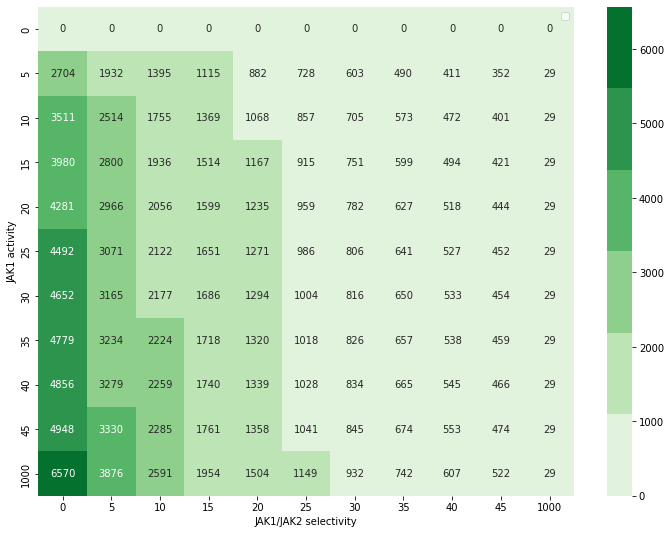

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


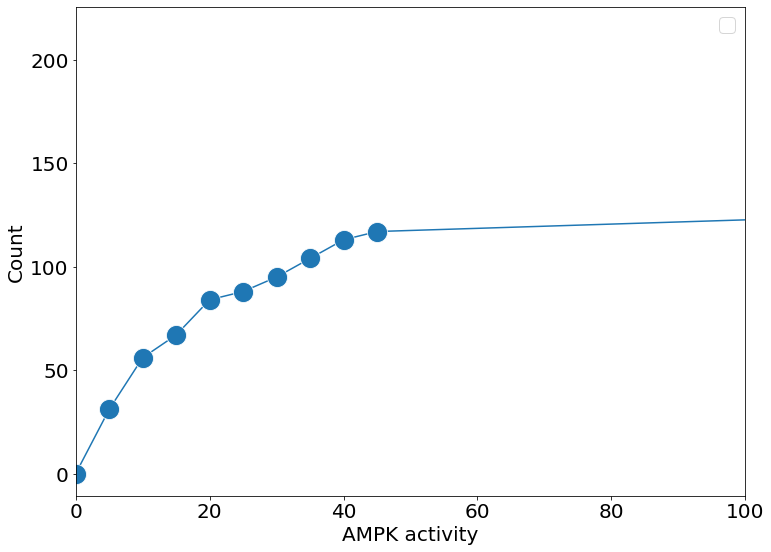

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

'''  First step find the scaffold of high activity for dual target  '''

JAK_ActFile="/public/home/zhangjie/Projects/autosarm/JAK1JAK2_Selectivity/Data/JAK_All_Mar22_PK.csv"
AMPK_ActFile="/public/home/zhangjie/Projects/autosarm/AMPK_Activity/Data/Active_cpds_PRKAB1_cano.csv"
FilterJAK=1
ActRange=[0,50]
SeleRange=[0,50]
FilterAMPK=1

ActList=range(ActRange[0],ActRange[1],int((ActRange[1]-ActRange[0])/10))
ActList=list(ActList)+[1000]
SelList=range(SeleRange[0],SeleRange[1],int((SeleRange[1]-SeleRange[0])/10))
SelList=list(SelList)+[1000]
### Filter CPDs of JAK
if FilterJAK:
    valueCols=["JAK1ToJAK2","JAK1","JAK2"]
    df_act_JAK=pd.read_csv(JAK_ActFile)
    df_act_JAK=float_row(df_act_JAK, cols=valueCols)
    df_act_JAK=df_act_JAK.dropna(subset=valueCols)
    # for irow in valueCols:
    #     df_act_JAK[irow]=df_act_JAK[irow].apply(np.log10)
    # df_act_JAK=df_act_JAK.replace(-np.inf, np.nan)
    # df_act_JAK=df_act_JAK.dropna(subset=valueCols)
    df_act_JAK['Cano_SMILES'] =df_act_JAK['SMILES'].apply(canonic_smiles)
    df_act_JAK['index']=df_act_JAK['Cano_SMILES'] 
    df_act_JAK=df_act_JAK.set_index("index")
    
    ###  count the CPDs above the selectivity range and below the activity range
    CPDCounts=[]
    Heatmap_data=[]
    for iActVal in ActList:
        iActList=[]
        for iSelVal in SelList:
            df_sele=df_act_JAK[(df_act_JAK['JAK1']<iActVal) & (df_act_JAK['JAK1ToJAK2']>iSelVal)]
            CPDCounts.append([iActVal,iSelVal,len(df_sele)])
            iActList.append(len(df_sele))
        Heatmap_data.append(iActList)
    df_CPDCount=pd.DataFrame(CPDCounts,columns=['JAK1 Activity','JAK1/JAK2 Selectivity','Count'])
    fig = plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 10})
    colormap = sns.color_palette("Greens")
    sns.heatmap(Heatmap_data, annot=True, fmt='d', cmap=colormap)
    # sns.barplot(data=df_CPDCount, x='Model', y='Count',hue='Pose')
    plt.legend()
    plt.xlabel("JAK1/JAK2 selectivity")
    plt.xticks(np.arange(11)+0.5,SelList)
    plt.yticks(np.arange(11)+0.5,ActList)
    plt.ylabel("JAK1 activity")
    plt.show() 
            
    
    
    
### Filter CPDs of AMPK
if FilterAMPK:
    valueCols=["EC50nM"]
    df_act_AMPK=pd.read_csv(AMPK_ActFile)
    df_act_AMPK=float_row(df_act_AMPK, cols=valueCols)
    df_act_AMPK=df_act_AMPK.dropna(subset=valueCols)
    # for irow in valueCols:
    #     df_act_AMPK[irow]=df_act_AMPK[irow].apply(np.log10)
    # df_act_AMPK=df_act_AMPK.replace(-np.inf, np.nan)
    # df_act_AMPK=df_act_AMPK.dropna(subset=valueCols)
    df_act_AMPK['Cano_SMILES'] =df_act_AMPK['SMILES'].apply(canonic_smiles)
    df_act_AMPK['index']=df_act_AMPK['Cano_SMILES'] 
    df_act_AMPK=df_act_AMPK.set_index("index")
    
    CPDCounts=[]
    for iActVal in ActList:
        df_sele=df_act_AMPK[(df_act_AMPK['EC50nM']<iActVal)]
        CPDCounts.append([iActVal,len(df_sele)])
    df_CPDCount=pd.DataFrame(CPDCounts, columns=['AMPK Activity','Count'])

    fig = plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 20})
    sns.lineplot(data=df_CPDCount, x='AMPK Activity', y='Count', markers=True, markersize=20, marker='o')
    plt.legend()
    plt.xlim(0,100)
    plt.xlabel("AMPK activity")
    plt.ylabel("Count")
    plt.show() 
    
'''  Select the active/high-selectivity CPDs  '''
iActVal=30
iSelVal=10
df_act_JAK=df_act_JAK[(df_act_JAK['JAK1']<iActVal) & (df_act_JAK['JAK1ToJAK2']>iSelVal)]
df_act_JAK.to_csv("DualTarget_JAKAMPK/Data/JAK_Act30Sel10.csv",index=None)

df_act_AMPK=df_act_AMPK[(df_act_AMPK['EC50nM']<iActVal)]
df_act_AMPK.to_csv("DualTarget_JAKAMPK/Data/AMPK_Act30.csv",index=None)
    

In [ ]:
'''  Create SARM AMPK (High selectivity and activity)  '''
''' Test of MLP program  '''
''' Create normal SARM table 
Can be based on the Scaffold or the full SMILES
'''
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
from IPython.display import display
import pandas as pd
from rdkit import Chem
import os,sys
sys.path.append('..')
from utils.common_utils import mapper,csvToExcel
from utils.sarm_utils import fragmentize,create_SARM,create_SARM_MLP
from my_toolset.my_utils import canonic_smiles,df_valid

act_csv_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act30.csv"
target="AMPKA30S10"
value_col=f"EC50nM"


save_folder=f"DualTarget_JAKAMPK/ScaffoldSARM/{target}_SMILES"
# act_csv_file="/public/home/zhangjie/Project_support/AIXB-5/Selectivity_Jan16/MedChemAct_Cano_Sele_JAN16.csv"
# save_folder="/public/home/zhangjie/Projects/autosarm/Sele78_Feb13/seleIdx20TLR820/Scaffold_All"
df_sele=pd.read_csv(act_csv_file)
df_sele=df_valid(df_sele,row_smi='SMILES')
df_sele[value_col]=df_sele[value_col].apply(is_number)
df_sele=pd.DataFrame(df_sele[df_sele[value_col]!=''])

if 'Cano_SMILES' not in df_sele.columns:
    df_sele['Cano_SMILES']=df_sele['SMILES'].apply(canonic_smiles)
df_sele['Scaffold']=[MurckoScaffoldSmilesFromSmiles(ismi) for ismi in df_sele["Cano_SMILES"]]
# df_sele.to_csv(act_csv_file, index=None)
act_CPDs=df_sele['Scaffold']

print(''' Fragment the scaffold! ''')
df_round1, df_round2=fragmentize(act_CPDs, n_jobs=20, drop_duplicate=False, pos_args={'RR':True, 'nRnR':True})
print("Creating SARM!")
df_table_info_left, df_table_info_right, df_table_info_combine=create_SARM(df_round1, df_round2, df_sele, save_folder=save_folder, smi_col="Scaffold", value_col=value_col, minimum_count=1, csv2excel=False,cal_table_stats=False, n_jobs=40)

In [55]:
'''  ---AMPK---  Combine combined table and fragment round 1 table   '''

'''  ---AMPK---  Construct fragment library: Combine Frag_round1 and Frag_round2  '''
combTable_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/ScaffoldSARM/AMPKA30S10_SMILES/Combine_Table_info.csv"
FRound1_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/ScaffoldSARM/AMPKA30S10_SMILES/Frag_round1_count.csv"
file_act="/public/home/zhangjie/Projects/autosarm/AMPK_Activity/Data/Active_cpds_PRKAB1_cano.csv"
infoCols=["EC50nM"] 
get_activity_info_p=partial(get_activity_info, file_act=file_act, cols=infoCols)
df_comb=combine_CombTab_Fround1(combTable_file, FRound1_file)
actInfo=df_comb['SMILES'].parallel_apply(get_activity_info_p)
actCols=[]
for idx,icol in enumerate(infoCols):
    actCols+=[f'{icol}_mean',f'{icol}_std',f'{icol}_median']
df_comb[actCols]=actInfo.to_list()
df_comb.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo.csv', index=None)


In [34]:
''' --AMPK--- Put the scaffolds into different groups based on similarity and parents info '''

df_comb=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo.csv')
df_comb['noDumSmi']=df_comb['SMILES'].parallel_apply(remove_dummy)
df_comb['Wt']=df_comb['SMILES'].parallel_apply(weight)
df_comb=df_comb.sort_values('Wt', ascending=False)  ## make the large scaffold in the front
scaff_NoDumScaff_dict,NoDumScaff_scaff_dict=scaffold_info(df_comb['SMILES'])#(["*Oc1nc2nc(*)ccc2[nH]1","*Oc1nc2nc(-c3ccc(*)cc3)ccc2[nH]1",'*c1ccc(-c2ccc(*)cc2)cc1',"*Oc1nc2nc(*)cnc2[nH]1"])
scaffoldsNodum=list(scaff_NoDumScaff_dict.values())
scaffoldFamily_p=partial(scaffoldFamily, scaffolds=scaffoldsNodum)
scafFamilys=mapper(40)(scaffoldFamily_p,scaffoldsNodum)
scafFam_dict={}
for idx,iscaf in enumerate(scaffoldsNodum):
    scafFam_dict[scaffoldsNodum[idx]]=scafFamilys[idx]
print(f"scafFam_dict= {scafFam_dict}")

'''  Assign Groups  '''
scafFam_dict_keys=list(scafFam_dict.keys())
for idx,ikey in enumerate(scafFam_dict_keys):
    if ikey in scafFam_dict.keys():
        all_members=list(scafFam_dict[ikey])
        new_members=list(scafFam_dict[ikey])
        count=0  ## to make the loop stable
        while len(new_members)>0:
            count+=1
            if count>1000: break
            tmp_members=[]
            for jkey in new_members:
                if jkey in scafFam_dict.keys() and jkey != ikey:
                    tmp_members+=scafFam_dict[jkey]
                    del scafFam_dict[jkey]
            tmp_members=list(set(tmp_members))
            new_members=list(set(tmp_members)-set(all_members))  
            all_members=list(set(all_members+tmp_members))  
        scafFam_dict[ikey]= all_members   
groupInfo_dict={}
for idx,iKey in enumerate(scafFam_dict.keys()):
    for jKey in scafFam_dict[iKey]:
        groupInfo_dict[jKey] = idx
for ismi in df_comb["noDumSmi"]:
    if ismi not in groupInfo_dict.keys():
        groupInfo_dict[ismi]=-1
df_comb['ScaffoldGroup']=df_comb.apply(lambda x: groupInfo_dict[x['noDumSmi']], axis=1)
df_comb=df_comb.sort_values('ScaffoldGroup',ascending=True)
df_comb.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo.csv', index=None)


scafFam_dict= {'S(=O)(=O)c1ccc(c2ccc(c3ccc4[nH]c(OC5CCCOC5)nc4c3)cc2)cc1': ['S(=O)(=O)c1ccc(c2ccc(c3ccc4[nH]c(OC5CCCOC5)nc4c3)cc2)cc1', 'c1ccc(c2ccc(c3ccc4[nH]c(OC5CCCOC5)nc4c3)cc2)cc1', 'Oc1nc2cc(c3ccc(c4ccc(S(=O)=O)cc4)cc3)ccc2[nH]1', 'c1nc2cc(c3ccc(c4ccc(S(=O)=O)cc4)cc3)ccc2[nH]1', 'c1ccc(c2ccc3[nH]c(OC4CCCOC4)nc3c2)cc1', 'Oc1nc2cc(c3ccc(c4ccccc4)cc3)ccc2[nH]1', 'Oc1nc2cc(c3ccc(c4ccccc4)cc3)ccc2[nH]1', 'c1nc2cc(c3ccc(c4ccccc4)cc3)ccc2[nH]1', 'c1ccc(c2ccc(c3ccc4[nH]cnc4c3)cc2)cc1', 'c1ccc2[nH]c(OC3CCCOC3)nc2c1', 'c1ccc(c2ccc(S(=O)=O)cc2)cc1', 'Oc1nc2cc(c3ccccc3)ccc2[nH]1', 'c1ccc(c2ccc3[nH]cnc3c2)cc1', 'c1ccc(c2ccccc2)cc1', 'c1ccc(c2ccccc2)cc1', 'c1ccc(S(=O)=O)cc1', 'Oc1nc2ccccc2[nH]1', 'c1ccc2[nH]cnc2c1', 'c1ccccc1'], 'Oc1nc2cc(c3ccc(c4ccc(S(=O)(=O)C5CCNCC5)cc4)cc3)ccc2[nH]1': ['Oc1nc2cc(c3ccc(c4ccc(S(=O)(=O)C5CCNCC5)cc4)cc3)ccc2[nH]1', 'c1nc2cc(c3ccc(c4ccc(S(=O)(=O)C5CCNCC5)cc4)cc3)ccc2[nH]1', 'Oc1nc2cc(c3ccc(c4ccc(S(=O)=O)cc4)cc3)ccc2[nH]1', 'c1nc2cc(c3ccc(c4ccc(S(=O)=O)cc4)cc3)cc

In [ ]:
''' --AMPK--- Prepare dock file for Scaffold selection '''

df_comb=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo.csv')  ## Fragment file
df_act=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act30.csv")  ## Active file of selected
df_act=df_act.dropna(subset=["EC50nM"])
df_comb['ID']=[f'Scaffold{i}' for i in range(len(df_comb))]
df_comb['Wt']=df_comb['SMILES'].apply(weight)
dockSmi_list=[]
for idx,irow in df_comb.iterrows():
    df_tmp=copy.deepcopy(df_act)
    # ismarts=add_singleBond_dummy(irow['SMILES'])
    match_core_p = partial(match_core, ismarts=irow['SMILES'])
    df_tmp['matched']=df_tmp['SMILES'].apply(match_core_p)  ##parallel_apply
    df_tmp=df_tmp[df_tmp['matched']==1]
    # df_tmp=df_tmp[:1]  ## Just chose 1
    get_full_core_p=partial(get_full_core, Core_smi=irow['SMILES'])
    df_tmp['CoreFullSmi']=df_tmp['SMILES'].apply(get_full_core_p)
    df_tmp=df_tmp.drop_duplicates(subset=['CoreFullSmi'])
    # df_tmp=df_tmp[:5]  ## Top 5 Scffold
    if len(df_tmp)>0:
        for jdx,jrow in df_tmp.iterrows():
            dockSmi_list.append([jrow['CoreFullSmi'],irow['SMILES'],irow['ID'],irow['ScaffoldGroup']])
    else:
        dockSmi_list.append(['',irow['SMILES'],irow['ID'],irow['ScaffoldGroup']])
        
df_dock=pd.DataFrame(dockSmi_list, columns=['SMILES','Core','ID','ScafGrp'])
df_dock['DummySMILES']=df_dock['SMILES']
df_dock['SMILES']=df_dock['SMILES'].apply(remove_dummy)
dock_saveFile="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Scaffold_Dock/AMPK_Scaffold_dock"
df_dock.to_csv(f"{dock_saveFile}.csv",index=None)

os.system(f"python /public/home/zhangjie/Projects/SVMXgBoost/svm_predict.py --model_file  /public/home/zhangjie/Project_support/AIXB-3/Active_datasets/Regression/PRKAB1_svm/svm_saved_model/svm_SVM_activity.pkl   --test_file {dock_saveFile}.csv  --job gen_eval --svm_task Regression --pred_label svm_PRKAB1 --n_jobs 2")

df_svm=pd.read_csv(f"{dock_saveFile}_svm_PRKAB1.csv")
df_svm=df_svm.groupby("ID").max()
df_svm.to_csv(f"{dock_saveFile}_svm_PRKAB1.csv",index=None)

os.system(f"python /public/home/zhangjie/Projects/r-group-decoration/csv2Excel.py   --csvFile  {dock_saveFile}_svm_PRKAB1.csv")



In [3]:
'''  ---AMPK---  Atom density in the pocket  '''
import math
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import json


ifGetAtomPos=0
gridAtom=0
pymolPse=1


sdfFiles=glob.glob("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/sdfs/*.sdf")
def get_atomPos(sdf):
    suppl = Chem.SDMolSupplier(sdf)
    mol=suppl[0]
    molNumAtoms=mol.GetNumAtoms()
    molAtoms=mol.GetAtoms()
    atomProps=[]
    if molNumAtoms>150:
        return atomProps
    conf = mol.GetConformer()
    # print(f"Molecule name: {mol.GetProp('_Name')}")
    # print(f"Number of atoms: {mol.GetNumAtoms()}")
    for i in range(molNumAtoms):
        molName=mol.GetProp('_Name')
        ipos=conf.GetAtomPosition(i)
        iAtomicNum=molAtoms[i].GetAtomicNum()
        iFormalCharge=molAtoms[i].GetFormalCharge()
        iIsAromatic=int(molAtoms[i].GetIsAromatic())
        iIsInRing=int(molAtoms[i].IsInRing())
        atomProps.append([molName,i,ipos.x,ipos.y,ipos.z,iAtomicNum,iFormalCharge,iIsAromatic,iIsInRing])
    # print(f"{i}:  {atomProps}")
    return atomProps

'''  Get all the position of atoms  ''' 
if ifGetAtomPos:
    atomPos_list=[]     
    for isdf in sdfFiles:
        atomPos=get_atomPos(isdf)
        for iatmPos in atomPos:
            atomPos_list.append(iatmPos)
    df_ActAtomPos=pd.DataFrame(atomPos_list,columns=['molName','atomIndex','X','Y','Z','AtomicNum','FormalCharge','IsAromatic','IsInRing'])
    df_ActAtomPos.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos.csv", index=None)
    print(f"Total atoms in the active set:  {len(atomPos_list)}.")

'''  Put the atoms into grids  ''' 
if gridAtom:
    grid_parameters={}  ## to save the grid parameters
    df_ActAtomPos=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos.csv")
    df_ActAtomPos[['X','Y','Z']]=df_ActAtomPos[['X','Y','Z']].round(1)
    xyzMax=df_ActAtomPos[['X','Y','Z']].max()
    xyzMin=df_ActAtomPos[['X','Y','Z']].min()
    grid_parameters['xyzMax']=xyzMax.to_dict()
    grid_parameters['xyzMin']=xyzMin.to_dict()
    print(f"xyzMax= {xyzMax}")
    print(f"xyzMin= {xyzMin}")
    cellWidth=1
    grid_parameters['cellWidth']=cellWidth
    xyzRange=(xyzMax-xyzMin)/cellWidth
    for iax in ['X','Y','Z']:
        xyzRange[iax]=int(math.ceil(xyzRange[iax]))
    xList=[xyzMin['X']+cellWidth*i for i in range(int(xyzRange['X']))]
    yList=[xyzMin['Y']+cellWidth*i for i in range(int(xyzRange['Y']))]
    zList=[xyzMin['Z']+cellWidth*i for i in range(int(xyzRange['Z']))]
    xyzIndex=list(itertools.product(xList,yList,zList))
    df_atmCount=pd.DataFrame(xyzIndex,columns=['X','Y','Z'])
    df_atmCount[['X','Y','Z']]=df_atmCount[['X','Y','Z']].astype(str)
    df_atmCount.set_index(['X','Y','Z'], drop=False, inplace=True)
    df_atmCount['Count_Carbon']=0  ## All Carbon
    df_atmCount['Count_ac']=0  ## All Carbon
    df_atmCount['Count_C']=0  ## All Carbon
    df_atmCount['Count_Oxygen']=0  ## All Carbon
    df_atmCount['Count_ao']=0  ## All Carbon
    df_atmCount['Count_O']=0  ## All Carbon
    df_atmCount['Count_Nitrogen']=0  ## All Carbon
    df_atmCount['Count_an']=0  ## All Carbon
    df_atmCount['Count_N']=0  ## All Carbon
    df_atmCount['Count_All']=0   ## All Atom
    for idx,irow in df_ActAtomPos.iterrows():
        ixPos=int((irow['X']-xyzMin['X'])/cellWidth)*cellWidth+xyzMin['X']
        ixPos=str(ixPos)
        iyPos=int((irow['Y']-xyzMin['Y'])/cellWidth)*cellWidth+xyzMin['Y']
        iyPos=str(iyPos)
        izPos=int((irow['Z']-xyzMin['Z'])/cellWidth)*cellWidth+xyzMin['Z']
        izPos=str(izPos)
        try:
            tmp=df_atmCount.loc[(ixPos,iyPos,izPos),'Count_All']
        except Exception as e:
            print(e)
            continue
        df_atmCount.loc[(ixPos,iyPos,izPos),'Count_All']+=1
        if irow['AtomicNum']==6:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Carbon']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_ac']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_C']+=1
        if irow['AtomicNum']==7:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Nitrogen']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_an']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_N']+=1
        if irow['AtomicNum']==8:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Oxygen']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_ao']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_O']+=1
                
    df_atmCount=df_atmCount[df_atmCount['Count_All']>0]
    df_atmCount.to_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos_gridCount.csv", index=None)
    with open("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos_gridCount_grid.json", "w") as outfile:
        json.dump(grid_parameters, outfile)
    
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    # im=ax.scatter(df_atmCount['X'],df_atmCount['Y'],df_atmCount['Z'],s=df_atmCount['Count_All'])
    fig=px.scatter_3d(df_atmCount,x='X',y='Y',z='Z',size='Count_All')
    fig.show()

if pymolPse==1:
    from importlib import reload
    import pymol
    import pandas as pd
    from pymol import cmd, stored
    reload(pymol)
    
    # pymol.finish_launching() 
    # pl = pymol2.PyMOL()
    # pl.start()
    # cmd=pl.cmd
    
    df_ActAtomPos=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos_gridCount.csv")
    countCols=['Count_All','Count_Carbon','Count_ac','Count_C','Count_Nitrogen','Count_an','Count_N','Count_Oxygen','Count_ao','Count_O']
    
    countColMax=df_ActAtomPos[countCols].max().max()
    for icountCol in countCols:
        # countColMax=df_ActAtomPos[icountCol].max()
        df_ActAtomPos[icountCol]=df_ActAtomPos[icountCol]/countColMax
        
    greyColors=['tin','black','zinc','Grey50']
    orangeColors=['lightorange','brightorange','olive','deepolive','orange']
    blueColors=['lightblue','slate','tv_blue','skyblue','blue']
    redColors=['salmon','deepsalmon','tv_red','raspberry','red']
    # pymol.finish_launching()
    for idx,irow in df_ActAtomPos.iterrows():
        iX=irow['X']
        iY=irow['Y']
        iZ=irow['Z']
        
        if irow['Count_All']>0:
            objName="Count_All_Site"
            cmd.pseudoatom(objName, name=f"DUM{idx}", pos=[iX, iY, iZ], vdw=irow['Count_All'], color="gray80", label="")
            cmd.show("spheres", objName)
            cmd.color("gray80", objName)
        
        for idxCol,icol in enumerate(['Count_Carbon','Count_C','Count_ac']):
            if irow[icol]>0:
                objName=f"{icol}_Site"
                cmd.pseudoatom(objName, name=f"DUM{idx}", pos=[iX, iY, iZ], vdw=irow[icol], color="", label="")
                cmd.show("spheres", objName)
                cmd.color(greyColors[-idxCol-1], objName)
        for idxCol,icol in enumerate(['Count_Nitrogen','Count_an','Count_N']):
            if irow[icol]>0:
                objName=f"{icol}_Site"
                cmd.pseudoatom(objName, name=f"DUM{idx}", pos=[iX, iY, iZ], vdw=irow[icol], color="", label="")
                cmd.show("spheres", objName)
                cmd.color(blueColors[-idxCol-1], objName)
        for idxCol,icol in enumerate(['Count_Oxygen','Count_ao','Count_O']):
            if irow[icol]>0:
                objName=f"{icol}_Site"
                cmd.pseudoatom(objName, name=f"DUM{idx}", pos=[iX, iY, iZ], vdw=irow[icol], color="", label="")
                cmd.show("spheres", objName)
                cmd.color(redColors[-idxCol-1], objName)
    cmd.bg_color("white")            
    cmd.set("sphere_transparency", 0.3, "all")        
    cmd.center("Count_All_Site")
    cmd.save("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_dummy.pse")
    pymol.finish_launching()

 PyMOL not running, entering library mode (experimental)


In [20]:
'''  Get position of fragments  '''
import math
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import json

grid_parameters="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos_gridCount_grid.json"    
act_sdf_folder="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/sdfs"
sdfFiles=glob.glob(f"{act_sdf_folder}/*.sdf") 
atmCount_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_Act_Dock/AMPK_actSet_atomPos_gridCount.csv"

motif="c12ccccc1[nH]cc2"  ## SMILES of most important fragment, cannot be SMARTS

def get_fragPos(frag,sdf):
    suppl = Chem.SDMolSupplier(sdf)
    mol=suppl[0]
    molNumAtoms=mol.GetNumAtoms()
    molAtoms=mol.GetAtoms()
    atomProps=[]
    if molNumAtoms>150:
        return atomProps
    conf = mol.GetConformer()
    # print(f"Molecule name: {mol.GetProp('_Name')}")
    # print(f"Number of atoms: {mol.GetNumAtoms()}")
    if '*' in frag:
        frag=remove_dummy(frag)
    smartMol=Chem.MolFromSmarts(frag)
    matched=mol.GetSubstructMatches(smartMol)
    if len(matched)<1:
        return atomProps
    smartRI=get_atomRingInfo(frag)
    # print(f"smartRI= {smartRI}")
    molRI=get_atomRingInfo(mol)
    for imatch in matched:
        submolRI=molRI[list(imatch)]
        # print(f"submolRI= {submolRI}")
        diff=np.absolute(smartRI-submolRI).sum()
        # print(matched)
        if diff==0:
            for i in imatch:
                molName=mol.GetProp('_Name')
                ipos=conf.GetAtomPosition(i)
                iAtomicNum=molAtoms[i].GetAtomicNum()
                iFormalCharge=molAtoms[i].GetFormalCharge()
                iIsAromatic=int(molAtoms[i].GetIsAromatic())
                iIsInRing=int(molAtoms[i].IsInRing())
                atomProps.append([molName,i,ipos.x,ipos.y,ipos.z,iAtomicNum,iFormalCharge,iIsAromatic,iIsInRing])
    # print(f"{i}:  {atomProps}")
    return atomProps

def get_frag_gridPos(frag,sdfFiles,atmCount_file,grid_parameters_json):
    with open(grid_parameters_json, "r") as outfile:
        grid_parameters=json.load(outfile)   ## Load grid parameters
        xyzMin=grid_parameters['xyzMin']
        xyzMax=grid_parameters['xyzMax']
        cellWidth=grid_parameters['cellWidth']
    df_atmCount=pd.read_csv(atmCount_file)  ## Keep all the dataframe size are the same
    countCols=['Count_All','Count_Carbon','Count_ac','Count_C','Count_Nitrogen','Count_an','Count_N','Count_Oxygen','Count_ao','Count_O']  
    df_atmCount[countCols]=0
    df_atmCount[['X','Y','Z']]=df_atmCount[['X','Y','Z']].astype(str)
    df_atmCount.set_index(['X','Y','Z'], drop=False, inplace=True)
    atomPos_list=[]
    for isdf in sdfFiles:
        atomPos=get_fragPos(frag,isdf)
        for iatmPos in atomPos:
            atomPos_list.append(iatmPos)
    df_ActAtomPos=pd.DataFrame(atomPos_list,columns=['molName','atomIndex','X','Y','Z','AtomicNum','FormalCharge','IsAromatic','IsInRing'])
    for idx,irow in df_ActAtomPos.iterrows():
        ixPos=int((irow['X']-xyzMin['X'])/cellWidth)*cellWidth+xyzMin['X']
        ixPos=str(ixPos)
        iyPos=int((irow['Y']-xyzMin['Y'])/cellWidth)*cellWidth+xyzMin['Y']
        iyPos=str(iyPos)
        izPos=int((irow['Z']-xyzMin['Z'])/cellWidth)*cellWidth+xyzMin['Z']
        izPos=str(izPos)
        try:
            tmp=df_atmCount.loc[(ixPos,iyPos,izPos),'Count_All']
        except Exception as e:
            print(e)
            continue
        df_atmCount.loc[(ixPos,iyPos,izPos),'Count_All']+=1
        if irow['AtomicNum']==6:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Carbon']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_ac']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_C']+=1
        if irow['AtomicNum']==7:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Nitrogen']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_an']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_N']+=1
        if irow['AtomicNum']==8:
            df_atmCount.loc[(ixPos,iyPos,izPos),'Count_Oxygen']+=1
            if irow['IsAromatic']==1:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_ao']+=1
            else:
                df_atmCount.loc[(ixPos,iyPos,izPos),'Count_O']+=1
                
    countCols=['Count_All','Count_Carbon','Count_ac','Count_C','Count_Nitrogen','Count_an','Count_N','Count_Oxygen','Count_ao','Count_O']
    countColMax=df_atmCount[countCols].max().max()
    for icountCol in countCols:
        # countColMax=df_ActAtomPos[icountCol].max()
        df_atmCount[icountCol]=df_atmCount[icountCol]/countColMax
    return  df_atmCount


def frag_position_score(frag,motif=motif,sdfFiles=sdfFiles,atmCount_file=atmCount_file,grid_parameters_json=grid_parameters):
    '''  Fragment position score relative to ref motif  '''
    df_motif=get_frag_gridPos(frag=motif,sdfFiles=sdfFiles,atmCount_file=atmCount_file,grid_parameters_json=grid_parameters_json) 
    df_frag=get_frag_gridPos(frag=frag,sdfFiles=sdfFiles,atmCount_file=atmCount_file,grid_parameters_json=grid_parameters_json) 
    score=(df_motif[countCols].astype(float)*df_frag[countCols].astype(float)).sum().sum()
    return score

df_comb=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo.csv')  ## Fragment file
df_comb['FragPosScore']=df_comb['SMILES'].parallel_apply(frag_position_score)

df_comb.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv',index=None)
os.system("python /public/home/zhangjie/Projects/r-group-decoration/csv2Excel.py  --csvFile  '/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv'")


('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.30000000000000004', '-31.6', '21.5')
('0.30000000000000004', '-30.6', '20.5')
('0.300000000000

In [26]:
'''  Select the fragments for dual-target compound enumeration  '''
def dummyAtom_number(ismi):
    '''  count the dummy atoms '''
    return ismi.count('*')
def seleForEnum(irow):
    ''' Select the fragments for enum  '''
    wtLim=300
    dummyAtom_count=1
    FragPos_score=1
    if irow['dummyCount']==dummyAtom_count and irow['Wt']<wtLim and irow['FragPosScore']>FragPos_score:
        return 1
    return 0
    
dfPoseScore=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv')
dfPoseScore['dummyCount']=dfPoseScore['SMILES'].apply(dummyAtom_number)
dfPoseScore['SeleEnum']=dfPoseScore.apply(lambda x: seleForEnum(x),axis=1)
dfPoseScore=dfPoseScore.sort_values(by=['SeleEnum','Wt'],ascending=False)
dfPoseScore.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv',index=None)
os.system("python /public/home/zhangjie/Projects/r-group-decoration/csv2Excel.py  --csvFile  /public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv")

/public/home/zhangjie/Projects/r-group-decoration/csv2Excel.py:9: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/public/home/zhangjie/anaconda3/envs/reinvent1/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


0

In [34]:
'''   Create tree of AMPK (Pending)  '''
import pandas as pd
from my_toolset.my_utils import get_mol,mapper
import re
from rdkit import Chem
import os,sys
import logging
from functools import reduce
sys.path.append("../../")
from utils.common_utils import mapper,csvToExcel,get_mol,compute_FP,canonic_smiles,float_row,heavy_atm_smiles,kekulize_smi

def fetch_table_info(df_table,smi):
    info=df_table.loc[smi,['Size']]
    # res_str=''
    # print(info)
    if type(info['Size'])==list:
        res_str=''+str(info['Size'].to_list())
    else:
        res_str=''+str(info['Size'])
    return res_str

class node():
    def __init__(self,smi) -> None:
        self.root=True
        self.SMILES=smi
        self.children=[]
        self.parents=[]
        
    def add_child(self,node):
        node.root=False
        self.children.append(node)
        
    def print_tree(self,df_table,opfile):
        empty_node=node('')
        tree_list=[]
        level=1
        print(f"Level {level}:  {self.SMILES} {fetch_table_info(df_table,self.SMILES)}")
        tree_list.append([[self.SMILES]])
        ilevel_smiles=[]
       
        for idx,inode in enumerate(self.children):
            print(f'node_{idx}',end=' ')
            opfile.write(f"node_{idx}  ")
            print(f"{inode.SMILES} {fetch_table_info(df_table, inode.SMILES)}", end=' ')
            opfile.write(f"{inode.SMILES} {fetch_table_info(df_table, inode.SMILES)} ")
            ilevel_smiles.append(inode.SMILES)
            # tmp_next_level_inodes.append(inode)
            print(' |',end=' ')
            opfile.write(' |')
        tree_list.append([ilevel_smiles])
        opfile.write(f"Level {level}:  {self.SMILES} {fetch_table_info(df_table,self.SMILES)}\n")
        next_level_nodes=self.children
        beforeLevel_with_child=[idx for idx,inode in enumerate(next_level_nodes)]
        smis_next_level_node=1
        count=0
        while smis_next_level_node>0:
            level+=1
            print(f"Level {level}:", end='  ')
            opfile.write(f"Level {level}:  ")
            tmp_next_level_inodes=[]
            ilevel_smiles=[]
            ilevel_with_child=[]
            inode_with_child_count=-1
            for idx,inode in enumerate(next_level_nodes):
                # print(inode.SMILES, end='  ')
                print(f'node_{idx}',end=' ')
                opfile.write(f"node_{idx}  ")
                if len(inode.children)>0:
                    
                    inode_smiles=[]
                    for inode_child in inode.children:
                        inode_with_child_count+=1
                        ilevel_with_child.append(inode_with_child_count)
                        print(f"{inode_child.SMILES} {fetch_table_info(df_table, inode_child.SMILES)}", end=' ')
                        opfile.write(f"{inode_child.SMILES} {fetch_table_info(df_table, inode_child.SMILES)} ")
                        inode_smiles.append(inode_child.SMILES)
                        tmp_next_level_inodes.append(inode_child)
                    ilevel_smiles.append(inode_smiles)
                    
                else:
                    ilevel_smiles.append([])
                    ilevel_with_child.append(-1)
                    # tmp_next_level_inodes.append(empty_node)
                print(' |',end=' ')
                opfile.write(' |')
                
            '''  Put current child SMILES in right position  '''
            print('beforeLevel_with_child', beforeLevel_with_child)
            print('ilevel_smiles', ilevel_smiles)
            ilevel_smiles_withPos=[[] for i in beforeLevel_with_child]
            for idxSmi, smiList in enumerate(ilevel_smiles):
                ilevel_smiles_withPos[beforeLevel_with_child.index(idxSmi)]=smiList
            beforeLevel_with_child=ilevel_with_child
            
                
                
            tree_list.append(ilevel_smiles)
            print(' ')
            opfile.write('\n')
            next_level_nodes=tmp_next_level_inodes
            # for i_next_level_node in next_level_nodes:
            smis_next_level_node=[i_next_level_node.SMILES for i_next_level_node in tmp_next_level_inodes if i_next_level_node.SMILES!='' ]
            smis_next_level_node=len(smis_next_level_node)
            
            
            count+=1
            if count>500:
                break
        return tree_list

def is_parent(parent,child):
    '''  If the compound is a substructure of another and don't have a molecule as its own substurcture, it's a parent.  '''
    parent=parent.replace('[nH]','n')  ## Correct the influence of ionization
    mol_parent=Chem.rdmolfiles.MolFromSmarts(parent)
    mol_child=Chem.rdmolfiles.MolFromSmiles(child,sanitize=False)
    mol_child.UpdatePropertyCache()
    matched=mol_child.GetSubstructMatches(mol_parent)
    if len(matched)>0:
        # print(matched)
        return True
    else:
        return False

def find_root(smi_list): 
    roots=[]      
    for ismi in smi_list:
        has_parent=False
        has_child=False 
        for jsmi in smi_list:
            if ismi==jsmi:
                continue
            # print(ismi,jsmi)
            if is_parent(ismi,jsmi):
                has_child=True
            if is_parent(jsmi,ismi):
                has_parent=True
            if has_child and has_parent:
                break
        if has_child and not has_parent:
            roots.append(ismi)
    roots=list(set(roots))
    return roots

def remove_dummy(smi):
    FragMol=Chem.MolFromSmiles(smi)
    matched=FragMol.GetSubstructMatches(Chem.MolFromSmarts("[#7][#0]"))
    atoms=FragMol.GetAtoms()
    for imatch in matched:
        atoms[imatch[1]].SetAtomicNum(1)
    # imol.UpdatePropertyCache()
    Chem.SanitizeMol(FragMol)
    FragMol=Chem.RemoveHs(FragMol)
    smi=Chem.MolToSmiles(FragMol)
    re_p=re.compile(r'\(\*\)|\*|\[\*\]|\-')
    ifrag_nodummy = re.sub(re_p, '', smi)  ## remove dummy atoms
    return ifrag_nodummy

def find_children(smi_list):
    res_dict={}
    for ismi in smi_list:
        res_dict[ismi]=[]
        for jsmi in smi_list:
            if ismi==jsmi: 
                continue
            if is_parent(ismi,jsmi):
                res_dict[ismi].append(jsmi)
    return res_dict

def find_parents(smi_list):
    res_dict={}
    for ismi in smi_list:
        res_dict[ismi]=[]
        for jsmi in smi_list:
            if ismi==jsmi: 
                continue
            if is_parent(jsmi,ismi):
                res_dict[ismi].append(jsmi)
    return res_dict

def real_sonNode(smi,children_smis,parent_dict):
    has_parent=set(children_smis) & set(parent_dict[smi])
    # print(has_parent)
    # sys.exit()
    if len(has_parent)>0:
        return False
    else:
        return True
    
    
''' Functions for bulding a complete Trees  '''
from my_toolset.drawing_utils import show_mols
from IPython.display import display
from rdkit.Chem import AllChem,Draw,rdFMCS
from rdkit import Chem
import graphviz
from pathlib import Path
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DCairo

def fetch_table_SMILES(df_table,smi):
    info=df_table.loc[smi,'SMILES']
    # print(info)
    try:
        # print(type(info))
        res_str=info.values[0]
        return res_str
    except:
        res_str=info
        return res_str

def fetch_table_info(df_table,smi):
    info=df_table.loc[smi,['Size']]
    # res_str=''
    # print(info)
    try:
        res_str=''+"%10s"%str(info['Size'].values)
    except:
        res_str=''+"%10s"%str(info['Size'])
    return res_str

def show_mols(smiles_mols,legends=[],subImgSize=(600,600)):
    '''Display multiple mols with legends'''
    mols=[Chem.rdmolfiles.MolFromSmiles(ismi,sanitize=False) for ismi in smiles_mols]
    mol_cls,legends_cls=[],[]
    for i in range(len(mols)):
        if mols[i]==None:
            continue
        mol_cls.append(mols[i])
        if len(legends)>i:
            legends_cls.append(legends[i])
        else:
            legends_cls.append('')
        Draw.MolToFile(mols[i], 'Images/test.png',size=(100,100))  ## strange thing withtout this below not working
    if len(mols)>3:
        molsPerRow=3
    else:
        molsPerRow=len(mols)
    png=Draw.MolsToGridImage(mols,molsPerRow=molsPerRow,subImgSize=subImgSize,legends=legends_cls,returnPNG=False) 
    return png

def show_mols_cairo(ismi,legend):
    mol = Chem.MolFromSmiles(ismi)
    drawer = MolDraw2DCairo(400, 400)
    drawer.drawOptions().legendFontSize = 160
    drawer.DrawMolecule(mol,legend=legend)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    return img
    
''' Build a Tree of all the important fragment  '''  
df_table=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/AMPK_CombTable_Round1_actInfo_poseScore.csv")
df_table=df_table[df_table['SeleEnum']==1]
Tree_dir="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/AMPK_Tree"
opfile=open(f'{Tree_dir}/Combine_Table_info_Tree.txt','w')

df_table["SMILESnoDummy"]=df_table["SMILES"].apply(remove_dummy)
SMILESnoDummy=df_table["SMILESnoDummy"].to_list()
df_table['index']=df_table["SMILESnoDummy"]
df_table=df_table.set_index('index')
# df_table['Items_count']=df_table['Items_count'].astype(int)
SMILESnoDummy=list(set(SMILESnoDummy))
roots=find_root(SMILESnoDummy)
# [SMILESnoDummy.remove(iroot) for iroot in roots]
children_dict=find_children(SMILESnoDummy)
parent_dict=find_parents(SMILESnoDummy)

tree_list=[]
tree_smile_list=[]
for itree,ismi in enumerate(roots):
    opfile.write('\n\n\n'+'-'*8+f" Tree {itree}: {ismi} "+'-'*8+'\n')
    inode=node(ismi)
    # inode.print_tree()
    next_level_inodes=[inode]
    while len(next_level_inodes)>0:
        for jdx,jnode in enumerate(next_level_inodes):
            children_smis=children_dict[jnode.SMILES]
            if len(children_smis)>0:
                for ichild_smi in children_smis:
                    if real_sonNode(ichild_smi,children_smis,parent_dict):
                        next_level_inodes[jdx].add_child(node(ichild_smi))
        tmp_next_level_inodes=[]
        for jnode in next_level_inodes:
            tmp_next_level_inodes.extend(jnode.children)
        next_level_inodes=tmp_next_level_inodes    
    itree_smiles=inode.print_tree(df_table=df_table,opfile=opfile)
    tree_smile_list.append(itree_smiles)
    tree_list.append(inode)
opfile.close()

''' Build tree of all the fragments in the table '''
os.system('mkdir Images')
for itree,itree_smiles in enumerate(tree_smile_list):
    d = graphviz.Digraph(filename=f'tree_{itree}.gv')
    d.node_attr["shape"] = "plaintext" # "box"
    d.node_attr["fixedsize"] = 'true'
    d.node_attr["height"] = '1'
    d.node_attr["width"] = '1'
    d.node_attr["label"] = ''

    for ilevel_idx,ilevel_smiles in enumerate(itree_smiles):
        # ilevel_smiles=[fetch_table_info_local(df_table,ismi) for ismi in ilevel_smiles]
        # print(ilevel_smiles)
        with d.subgraph() as s:
            s.attr(rank='same')
            count=-1
            for inode,cpds_node in enumerate(ilevel_smiles):
                for icpd in cpds_node:
                    # print(f"icpd={icpd}")
                    count+=1
                    if icpd=='':
                        continue
                    icpd_dummy=fetch_table_SMILES(df_table,icpd)
                    # print(icpd)
                    # img=show_mols([icpd_dummy],legends=[fetch_table_info(df_table,icpd)])
                    # img.save(f"Images/L{ilevel_idx}_{count}.png")
                    img=show_mols_cairo(icpd_dummy,fetch_table_info(df_table,icpd))
                    with open(f"Images/L{ilevel_idx}_{count}.png", 'wb') as f:
                        f.write(img)
                    s.node(f'L{ilevel_idx}_{count}', image=f"Images/L{ilevel_idx}_{count}.png")
                    if ilevel_idx>0:
                        d.edge(f'L{ilevel_idx-1}_{inode}',f'L{ilevel_idx}_{count}',penwidth='0.2', arrowsize='0.2')
        d.view()   
os.system(f'mv *.gv *.pdf Images {Tree_dir}')


Level 1:  c1nc2cc(c3ccc(c4ccccc4)cc3)ccc2[nH]1        (5)
node_0 Oc1nc2cc(c3ccc(c4ccccc4)cc3)ccc2[nH]1        (5)  | Level 2:  node_0  | beforeLevel_with_child [0]
ilevel_smiles [[]]
 
Level 1:  c1nc2nc(c3ccc(c4ccccc4)cc3)ccc2[nH]1        (7)
node_0 Oc1nc2nc(c3ccc(c4ccccc4)cc3)ccc2[nH]1        (7)  | Level 2:  node_0  | beforeLevel_with_child [0]
ilevel_smiles [[]]
 
Level 1:  c1ccc2[nH]c(OC3CCCOC3)nc2c1        (5)
node_0 c1ccc(c2ccc3[nH]c(OC4CCCOC4)nc3c2)cc1       (24)  | Level 2:  node_0  | beforeLevel_with_child [0]
ilevel_smiles [[]]
 
Level 1:  c1ccc2[nH]ccc2c1       (10)
node_0 c1ccc(c2ccc3[nH]ccc3c2)cc1       (28)  | Level 2:  node_0 Oc1ccc(c2ccc3[nH]ccc3c2)cc1        (6)  | beforeLevel_with_child [0]
ilevel_smiles [['Oc1ccc(c2ccc3[nH]ccc3c2)cc1']]
 
Level 3:  node_0 COc1ccc(c2ccc3[nH]ccc3c2)cc1        (6)  | beforeLevel_with_child [0]
ilevel_smiles [['COc1ccc(c2ccc3[nH]ccc3c2)cc1']]
 
Level 4:  node_0 CCOc1ccc(c2ccc3[nH]ccc3c2)cc1        (3)  | beforeLevel_with_child [0]
ilevel

Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 
Unable to init server: Could not conn

256

#######################################################################################
       ###############   BELOW IS JAK SECTION     #############################
#######################################################################################

In [ ]:
'''  Create SARM JAK (High selectivity and activity)  '''
''' Test of MLP program  '''
''' Create normal SARM table 
Can be based on the Scaffold or the full SMILES
'''
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric,MurckoScaffoldSmiles,MurckoScaffoldSmilesFromSmiles
from IPython.display import display
import pandas as pd
from rdkit import Chem
import os,sys
sys.path.append('..')
from utils.common_utils import mapper,csvToExcel
from utils.sarm_utils import fragmentize,create_SARM,create_SARM_MLP
from my_toolset.my_utils import canonic_smiles,df_valid

act_csv_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Act30Sel10.csv"
target="JAKA30S10"
value_col=f"JAK1"

save_folder=f"DualTarget_JAKAMPK/ScaffoldSARM/{target}_SMILES"
# act_csv_file="/public/home/zhangjie/Project_support/AIXB-5/Selectivity_Jan16/MedChemAct_Cano_Sele_JAN16.csv"
# save_folder="/public/home/zhangjie/Projects/autosarm/Sele78_Feb13/seleIdx20TLR820/Scaffold_All"
df_sele=pd.read_csv(act_csv_file)
df_sele=df_valid(df_sele,row_smi='SMILES')
df_sele[value_col]=df_sele[value_col].parallel_apply(is_number)
df_sele=pd.DataFrame(df_sele[df_sele[value_col]!=''])

if 'Cano_SMILES' not in df_sele.columns:
    df_sele['Cano_SMILES']=df_sele['SMILES'].parallel_apply(canonic_smiles)
df_sele['Scaffold']=[MurckoScaffoldSmilesFromSmiles(ismi) for ismi in df_sele["Cano_SMILES"]]
# df_sele.to_csv(act_csv_file, index=None)
act_CPDs=df_sele['Scaffold']

print(''' Fragment the scaffold! ''')
df_round1, df_round2=fragmentize(act_CPDs, n_jobs=40, drop_duplicate=False, pos_args={'RR':True, 'nRnR':True})
print("Creating SARM!")
df_table_info_left, df_table_info_right, df_table_info_combine=create_SARM(df_round1, df_round2, df_sele, save_folder=save_folder, smi_col="Scaffold", value_col=value_col, minimum_count=5, csv2excel=True,cal_table_stats=True, n_jobs=40)

In [13]:
'''  Combine combined table and fragment round 1 table   '''

'''  ---JAK---  Construct fragment library: Combine Frag_round1 and Frag_round2  '''
combTable_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/ScaffoldSARM/JAKA30S10_SMILES/Combine_Table_info.csv"
FRound1_file="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/ScaffoldSARM/JAKA30S10_SMILES/Frag_round1_count.csv"
file_act="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Act30Sel10.csv"
infoCols=["JAK1","JAK1ToJAK2"] 
get_activity_info_p=partial(get_activity_info, file_act=file_act, cols=infoCols)
df_comb=combine_CombTab_Fround1(combTable_file, FRound1_file)
actInfo=df_comb['SMILES'].parallel_apply(get_activity_info_p)
actCols=[]
for idx,icol in enumerate(infoCols):
    actCols+=[f'{icol}_mean',f'{icol}_std',f'{icol}_median']
actInfo=pd.DataFrame(actInfo.to_list())
actInfo.columns=actCols
for icol in actCols:
    df_comb[icol]=actInfo[icol].to_list()
df_comb.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo.csv', index=None)

In [30]:
''' --JAK--- Put the scaffolds into different groups based on similarity and parents info '''


df_comb=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo.csv')
df_comb['noDumSmi']=df_comb['SMILES'].parallel_apply(remove_dummy)
df_comb['Wt']=df_comb['SMILES'].parallel_apply(weight)
df_comb=df_comb.sort_values('Wt', ascending=False)  ## make the large scaffold in the front
scaff_NoDumScaff_dict,NoDumScaff_scaff_dict=scaffold_info(df_comb['SMILES'])#(["*Oc1nc2nc(*)ccc2[nH]1","*Oc1nc2nc(-c3ccc(*)cc3)ccc2[nH]1",'*c1ccc(-c2ccc(*)cc2)cc1',"*Oc1nc2nc(*)cnc2[nH]1"])
scaffoldsNodum=list(scaff_NoDumScaff_dict.values())
scaffoldFamily_p=partial(scaffoldFamily, scaffolds=scaffoldsNodum)
scafFamilys=mapper(40)(scaffoldFamily_p,scaffoldsNodum)
scafFam_dict={}
for idx,iscaf in enumerate(scaffoldsNodum):
    scafFam_dict[scaffoldsNodum[idx]]=scafFamilys[idx]
print(f"scafFam_dict= {scafFam_dict}")

'''  Assign Groups  '''
scafFam_dict_keys=list(scafFam_dict.keys())
for idx,ikey in enumerate(scafFam_dict_keys):
    if ikey in scafFam_dict.keys():
        all_members=list(scafFam_dict[ikey])
        new_members=list(scafFam_dict[ikey])
        count=0  ## to make the loop stable
        while len(new_members)>0:
            count+=1
            if count>1000: break
            tmp_members=[]
            for jkey in new_members:
                if jkey in scafFam_dict.keys() and jkey != ikey:
                    tmp_members+=scafFam_dict[jkey]
                    del scafFam_dict[jkey]
            tmp_members=list(set(tmp_members))
            new_members=list(set(tmp_members)-set(all_members))  
            all_members=list(set(all_members+tmp_members))  
        scafFam_dict[ikey]= all_members   
groupInfo_dict={}
for idx,iKey in enumerate(scafFam_dict.keys()):
    for jKey in scafFam_dict[iKey]:
        groupInfo_dict[jKey] = idx
for ismi in df_comb["noDumSmi"]:
    if ismi not in groupInfo_dict.keys():
        groupInfo_dict[ismi]=-1
df_comb['ScaffoldGroup']=df_comb.apply(lambda x: groupInfo_dict[x['noDumSmi']], axis=1)
df_comb=df_comb.sort_values(by=['ScaffoldGroup','Wt'], ascending=True)
df_comb.to_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo.csv', index=None)


scafFam_dict= {'CCOC(=O)N1CCCC(n2ccc(Nc3ccccc3)n2)C1': ['CCOC(=O)N1CCCC(n2ccc(Nc3ccccc3)n2)C1', 'COC(=O)N1CCCC(n2ccc(Nc3ccccc3)n2)C1', 'OC(=O)N1CCCC(n2ccc(Nc3ccccc3)n2)C1', 'C(=O)N1CCCC(n2ccc(Nc3ccccc3)n2)C1', 'CN1CCCC(n2ccc(Nc3ccccc3)n2)C1', 'c1ccc(Nc2ccn(C3CCCNC3)n2)cc1', 'CCOC(=O)N1CCCC(n2ccc(N)n2)C1', 'COC(=O)N1CCCC(n2ccc(N)n2)C1', 'CCOC(=O)N1CCCC(n2cccn2)C1', 'OC(=O)N1CCCC(n2ccc(N)n2)C1', 'COC(=O)N1CCCC(n2cccn2)C1', 'OC(=O)N1CCCC(n2cccn2)C1', 'C(=O)N1CCCC(n2ccc(N)n2)C1', 'CN1CCCC(n2ccc(N)n2)C1', 'C(=O)N1CCCC(n2cccn2)C1', 'Nc1ccn(C2CCCNC2)n1', 'Nc1ccn(C2CCCNC2)n1', 'CN1CCCC(n2cccn2)C1', 'c1ccc(Nc2cc[nH]n2)cc1', 'c1cccc(Nc2cc[nH]n2)c1', 'c1ccc(Nc2cc[nH]n2)cc1', 'c1ccn(C2CCCNC2)n1', 'c1ccn(C2CCCNC2)n1', 'c1ccc(N)cc1', 'c1cccc(N)c1', 'Nc1cc[nH]n1', 'c1ccccc1', 'c1ccccc1', 'c1cc[nH]n1'], 'CCOC(=O)N1CCC(n2ccc(Nc3ccccc3)n2)CC1': ['CCOC(=O)N1CCC(n2ccc(Nc3ccccc3)n2)CC1', 'COC(=O)N1CCC(n2ccc(Nc3ccccc3)n2)CC1', 'OC(=O)N1CCC(n2ccc(Nc3ccccc3)n2)CC1', 'C(=O)N1CCC(n2ccc(Nc3ccccc3)n2)CC1', 'CN1CC

In [ ]:
''' ---JAK--- Prepare dock file for Scaffold selection  (abandoned) '''

df_comb=pd.read_csv('/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK1_CombTable_Round1_actInfo.csv')  ## Fragment file
df_act=pd.read_csv("/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Act30Sel10.csv")  ## Active file of selected
df_act=df_act.dropna(subset=["JAK1"])
df_comb['ID']=[f'Scaffold{i}' for i in range(len(df_comb))]
df_comb['Wt']=df_comb['SMILES'].apply(weight)
dockSmi_list=[]
for idx,irow in df_comb.iterrows():
    print(f"Working on {idx}/{len(df_comb)}")
    df_tmp=copy.deepcopy(df_act)
    # ismarts=add_singleBond_dummy(irow['SMILES'])
    match_core_p = partial(match_core, ismarts=irow['SMILES'])
    df_tmp['matched']=df_tmp['SMILES'].parallel_apply(match_core_p)  ##parallel_apply
    df_tmp=df_tmp[df_tmp['matched']==1]
    # df_tmp=df_tmp[:1]  ## Just chose 1
    get_full_core_p=partial(get_full_core, Core_smi=irow['SMILES'])
    df_tmp['CoreFullSmi']=df_tmp['SMILES'].apply(get_full_core_p)
    df_tmp=df_tmp.drop_duplicates(subset=['CoreFullSmi'])
    # df_tmp=df_tmp[:5]  ## Top 5 Scffold
    for jdx,jrow in df_tmp.iterrows():
        for jdx,jrow in df_tmp.iterrows():
            dockSmi_list.append([jrow['CoreFullSmi'],irow['SMILES'],irow['ID'],irow['ScaffoldGroup']])
        
df_dock=pd.DataFrame(dockSmi_list, columns=['SMILES','Core','ID','ScafGrp'])
df_dock['DummySMILES']=df_dock['SMILES']
df_dock['SMILES']=df_dock['SMILES'].parallel_apply(remove_dummy)
df_dock=sort_mol_sim_df(df_dock, col='SMILES')
save_dockFile="/public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Scaffold_Dock/JAK1_CombTable_Round1_actInfo_dock.csv"
df_dock.to_csv(save_dockFile, index=None)

os.system(f"python /public/home/zhangjie/Projects/SVMXgBoost/svm_predict.py --model_file  /public/home/zhangjie/Project_support/AIXB-3/Active_datasets/Regression/JAK1_svm/svm_saved_model/svm_SVM_activity.pkl   --test_file  /public/home/zhangjie/Projects/autosarm/DualTarget_JAKAMPK/Data/JAK_Scaffold_Dock/JAK1_CombTable_Round1_actInfo_dock.csv  --job gen_eval --svm_task Regression --pred_label svm_JAK1 --n_jobs 2")


os.system(f"python /public/home/zhangjie/Projects/r-group-decoration/csv2Excel.py   --csvFile  {save_dockFile}")
    

